# <a id='env'> Ortamın Ayarlanması</a>

In [2]:
from IPython.display import clear_output
!pip3 install imutils
clear_output()

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
from collections import Counter

import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import Flatten , Activation , Dense
from keras import layers
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50, preprocess_input
#from keras.applications.efficientnet import EfficientNetB0, preprocess_input

from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam , RMSprop
from keras.callbacks import EarlyStopping , ModelCheckpoint
import tensorflow as tf
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <a id='env'>SINIFLARI AYARLAMA</a>

In [6]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST TRAIN/BENGIN_CASES TRAIN/MALIGNANT_CASES TRAIN/NORMAL_CASES TEST/BENGIN_CASES TEST/MALIGNANT_CASES TEST/NORMAL_CASES

!tree -d

.
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       └── DATA -> /content/drive/.shortcut-targets-by-id/1k5qXk8KhhmrTXzKlFmi-regpFoty8yR-/DATA
├── sample_data
├── TEST
│   ├── BENGIN_CASES
│   ├── MALIGNANT_CASES
│   └── NORMAL_CASES
└── TRAIN
    ├── BENGIN_CASES
    ├── MALIGNANT_CASES
    └── NORMAL_CASES

13 directories


# <a id='env'>VERIYI BÖLMEK</a>

In [7]:
IMG_PATH = '/content/drive/MyDrive/DATA/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.95*IMG_NUM:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TEST/'+ CLASS.upper() + '/' + FILE_NAME)




# <a id='import'> Veri YÜKLEME ve Ön İşleme</a>

In [8]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)

    print(labels)

    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels




In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)


100%|██████████| 3/3 [00:04<00:00,  1.54s/it]


{0: 'BENGIN_CASES', 1: 'MALIGNANT_CASES', 2: 'NORMAL_CASES'}
1043 images loaded from TRAIN/ directory.


100%|██████████| 3/3 [00:00<00:00,  8.01it/s]

{0: 'BENGIN_CASES', 1: 'MALIGNANT_CASES', 2: 'NORMAL_CASES'}
54 images loaded from TEST/ directory.


Let's take a look at the distribution of classes among sets:

# <a id='env'>sınıfların kümeler arasında dağılımı</a>


In [11]:

y = dict()
y[0] = []
y[1] = []
y[2] = []
for set_name in (y_train, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))


trace0 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[0],
    name='BENGIN_CASES',
    marker=dict(color='#ffcc00'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[1],
    name='MALIGNANT_CASES',
    marker=dict(color='#ff0000'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Test Set'],
    y=y[2],
    name='NORMAL_CASES',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
data = [trace0, trace1,trace2]
layout = go.Layout(
    title='Her setteki sınıf sayısı',
    xaxis={'title': 'Set'},
    yaxis={'title': 'sayı'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [12]:
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Class: {}'.format(labels_dict[index]))
        plt.show()

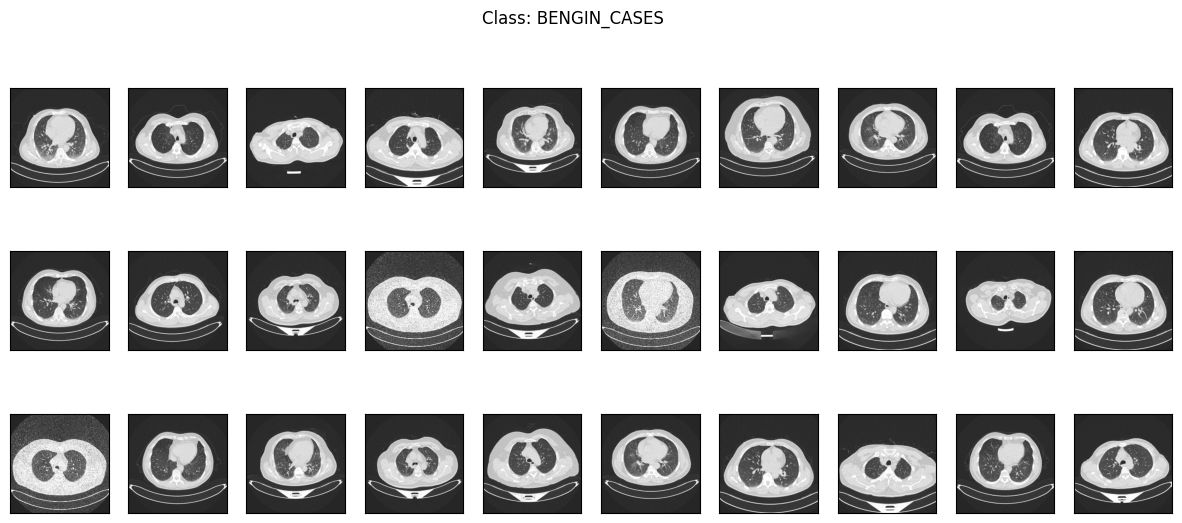

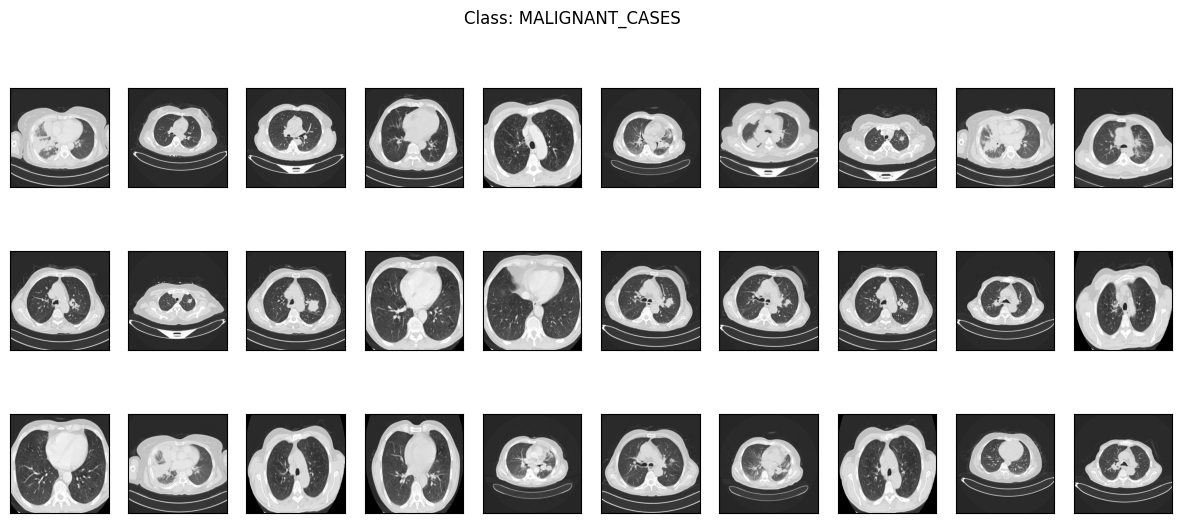

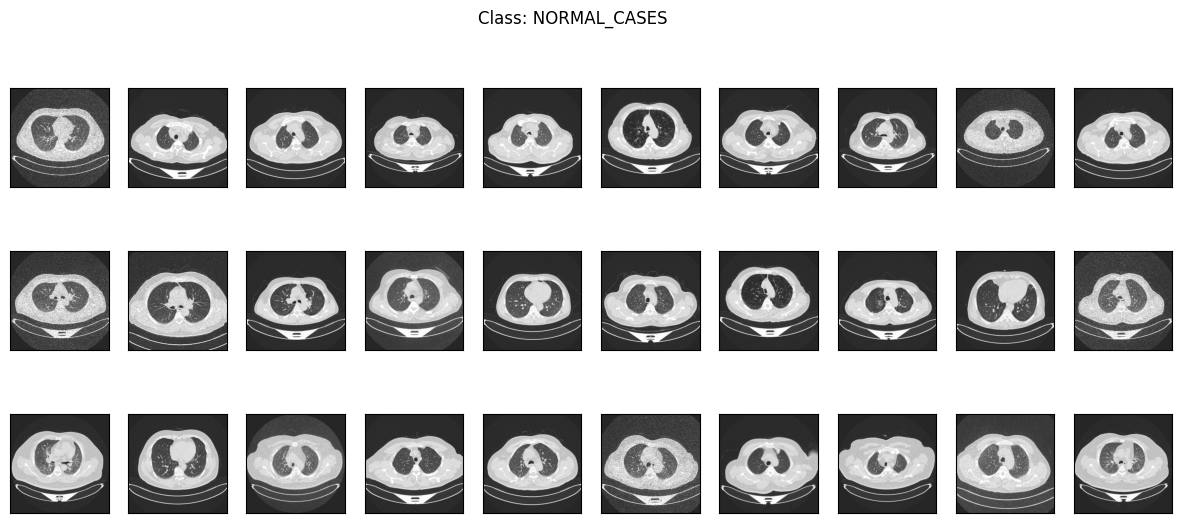

In [13]:
plot_samples(X_train, y_train, labels, 30)

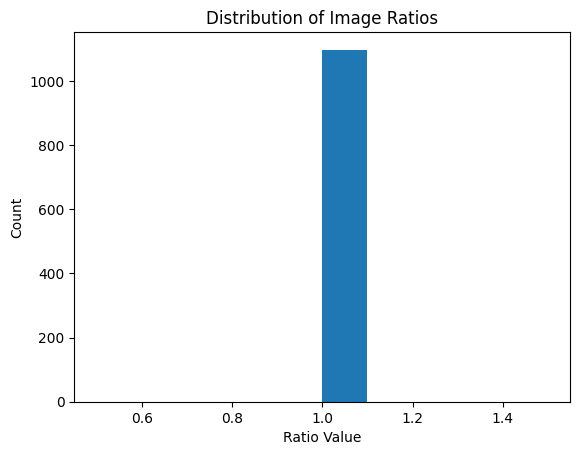

In [14]:
RATIO_LIST = []
for sett in (X_train, X_test):
    for img in sett:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

# <a id='env'>VERI NORMALIZESI</a>

OpenCV ile konturlarda uç noktaları bulma

örnek

In [15]:

import cv2
import imutils
import numpy as np

def crop_imgs(set_name, add_pixels_value=0, target_size=(224, 224)):
    """
    Finds the extreme points on the image, crops the rectangular region, and applies histogram equalization.
    """
    set_new = []

    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Apply histogram equalization to the grayscale version of the cropped image
        new_img_gray = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        new_img_gray_eq = cv2.equalizeHist(new_img_gray)

        # Merge the equalized grayscale image with the original color channels
        new_img_eq = cv2.merge([new_img_gray_eq] * 3)

        new_img_resized = cv2.resize(new_img_eq, target_size)
        set_new.append(new_img_resized)

    return np.array(set_new)


# <a id='env'>Train Teste uygulamak</a>

In [17]:
X_train_crop = crop_imgs(set_name=X_train)
X_test_crop = crop_imgs(set_name=X_test)

train setinden 10 örnek

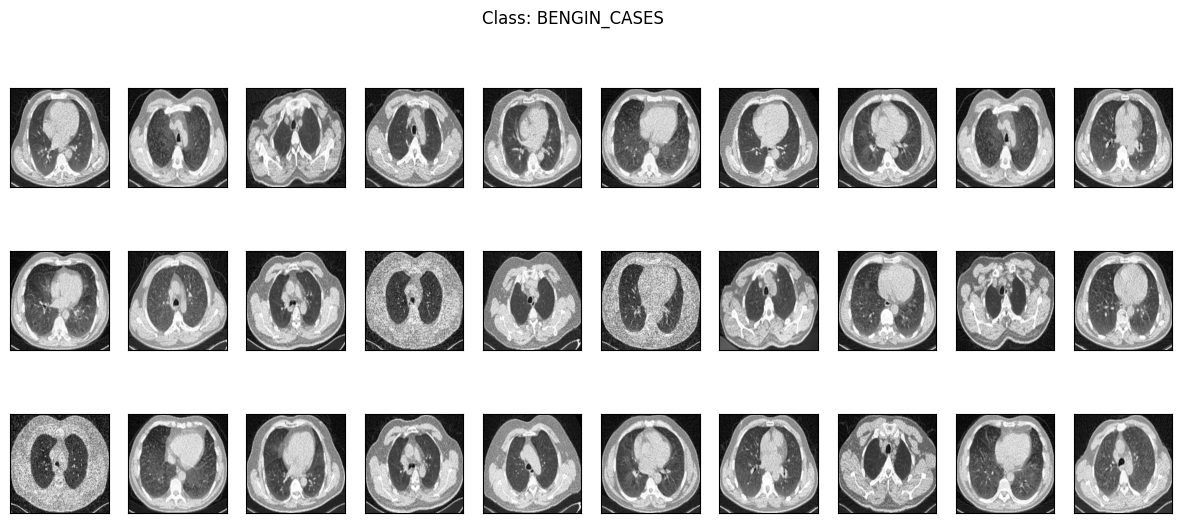

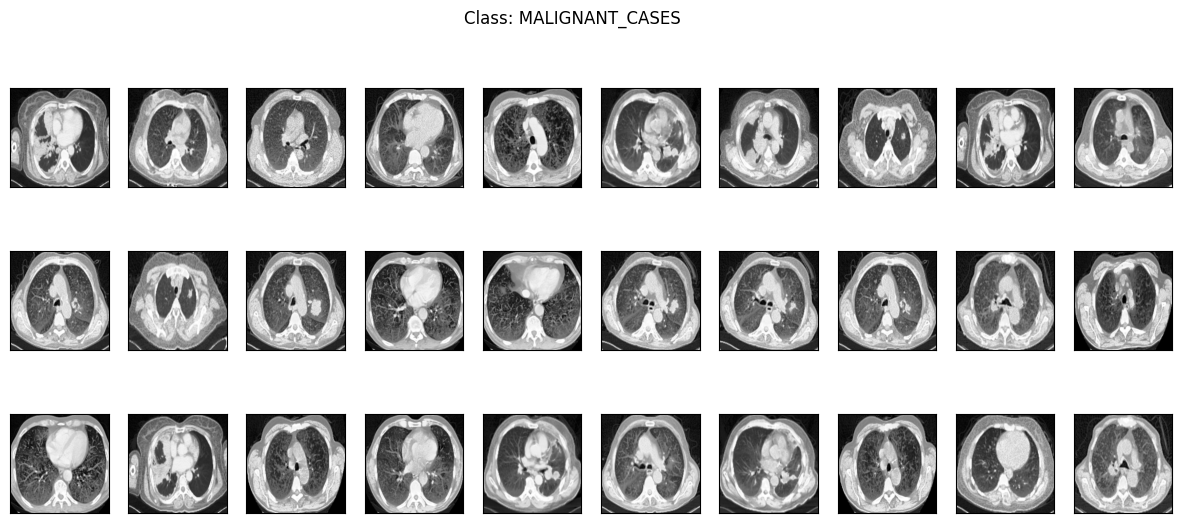

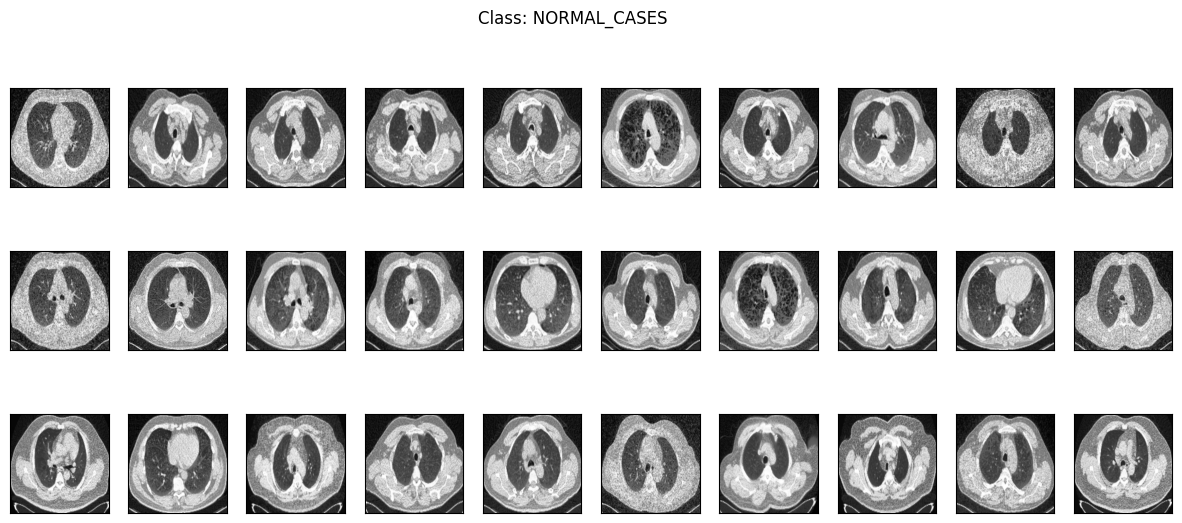

In [18]:

plot_samples(X_train_crop, y_train, labels, 30)


# <a id='env'>Kesilen görüntüleri farkli dosyaya kaydetmek</a>


In [19]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'BENGIN_CASES/'+str(i)+'.jpg', img)
        elif imclass == 1:
             cv2.imwrite(folder_name+'MALIGNANT_CASES/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(folder_name+'NORMAL_CASES/'+str(i)+'.jpg', img)
        i += 1

In [20]:

!mkdir TRAIN_CROP TEST_CROP  TRAIN_CROP/BENGIN_CASES TRAIN_CROP/MALIGNANT_CASES TRAIN_CROP/NORMAL_CASES TEST_CROP/BENGIN_CASES TEST_CROP/MALIGNANT_CASES TEST_CROP/NORMAL_CASES


save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

### <a id='Veri Artırma'>Veri Artırma</a>

In [21]:
TRAIN_DIR = 'TRAIN_CROP/'
TEST_DIR = 'TEST_CROP/'

BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
   rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    preprocessing_function=preprocess_input,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED,
    subset='training'
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    shuffle=True,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED,
    subset='validation'

)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=RANDOM_SEED
)

Found 940 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Found 54 images belonging to 3 classes.


## <a id='build'> Model Hazirlama</a>

In [22]:
from keras.layers import BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout, Dense

input_shape = (224, 224, 3)
num_classes = 3
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


## <a id='perf'> Eğitim</a>


In [23]:

EPOCHS = 45
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')


resnet50_checkpoint = ModelCheckpoint('resnet50_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


history=model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=[resnet50_checkpoint, early_stopping])


Epoch 1/45
30/30 [==============================] - ETA: 0s - loss: 0.6315 - accuracy: 0.7394
Epoch 1: val_accuracy improved from -inf to 0.75728, saving model to resnet50_model.h5
30/30 [==============================] - 78s 887ms/step - loss: 0.6315 - accuracy: 0.7394 - val_loss: 0.5806 - val_accuracy: 0.7573
Epoch 2/45
30/30 [==============================] - ETA: 0s - loss: 0.4021 - accuracy: 0.8340
Epoch 2: val_accuracy improved from 0.75728 to 0.85437, saving model to resnet50_model.h5
30/30 [==============================] - 23s 755ms/step - loss: 0.4021 - accuracy: 0.8340 - val_loss: 0.4126 - val_accuracy: 0.8544
Epoch 3/45
30/30 [==============================] - ETA: 0s - loss: 0.3597 - accuracy: 0.8521
Epoch 3: val_accuracy did not improve from 0.85437
30/30 [==============================] - 20s 679ms/step - loss: 0.3597 - accuracy: 0.8521 - val_loss: 0.5612 - val_accuracy: 0.7961
Epoch 4/45
30/30 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8713


## <a id='perf'> Model Performance</a>

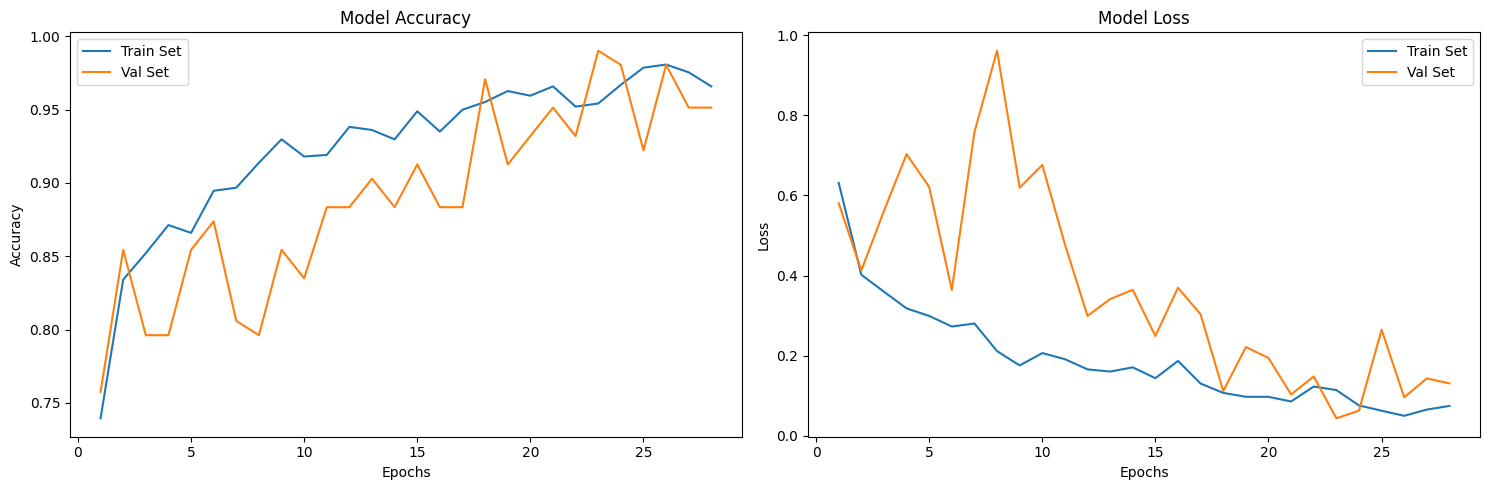

In [24]:
# plot model performance

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()



## <a id='perf'> Test</a>


2/2 [==============================] - 2s 1s/step
Test Accuracy = 0.91
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           1       1.00      1.00      1.00        28
           2       1.00      0.75      0.86        20

    accuracy                           0.91        54
   macro avg       0.85      0.92      0.85        54
weighted avg       0.95      0.91      0.91        54



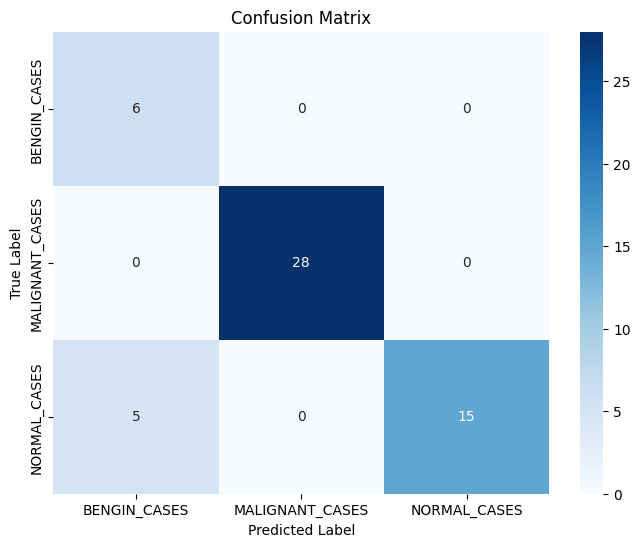

In [25]:



from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Validate on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Assuming y_test contains the true labels
accuracy = accuracy_score(y_test, predicted_labels)
print('Test Accuracy = %.2f' % accuracy)

# Print classification report
print(classification_report(y_test, predicted_labels))

# Confusion matrix
confusion_mtx = confusion_matrix(y_test, predicted_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming labels is a dictionary with class labels
class_labels = list(labels.values())
plot_confusion_matrix(confusion_mtx, classes=class_labels)


In [28]:

model.save('2023-11_Resnet50_model.h5')

1/1 [==============================] - 0s 22ms/step


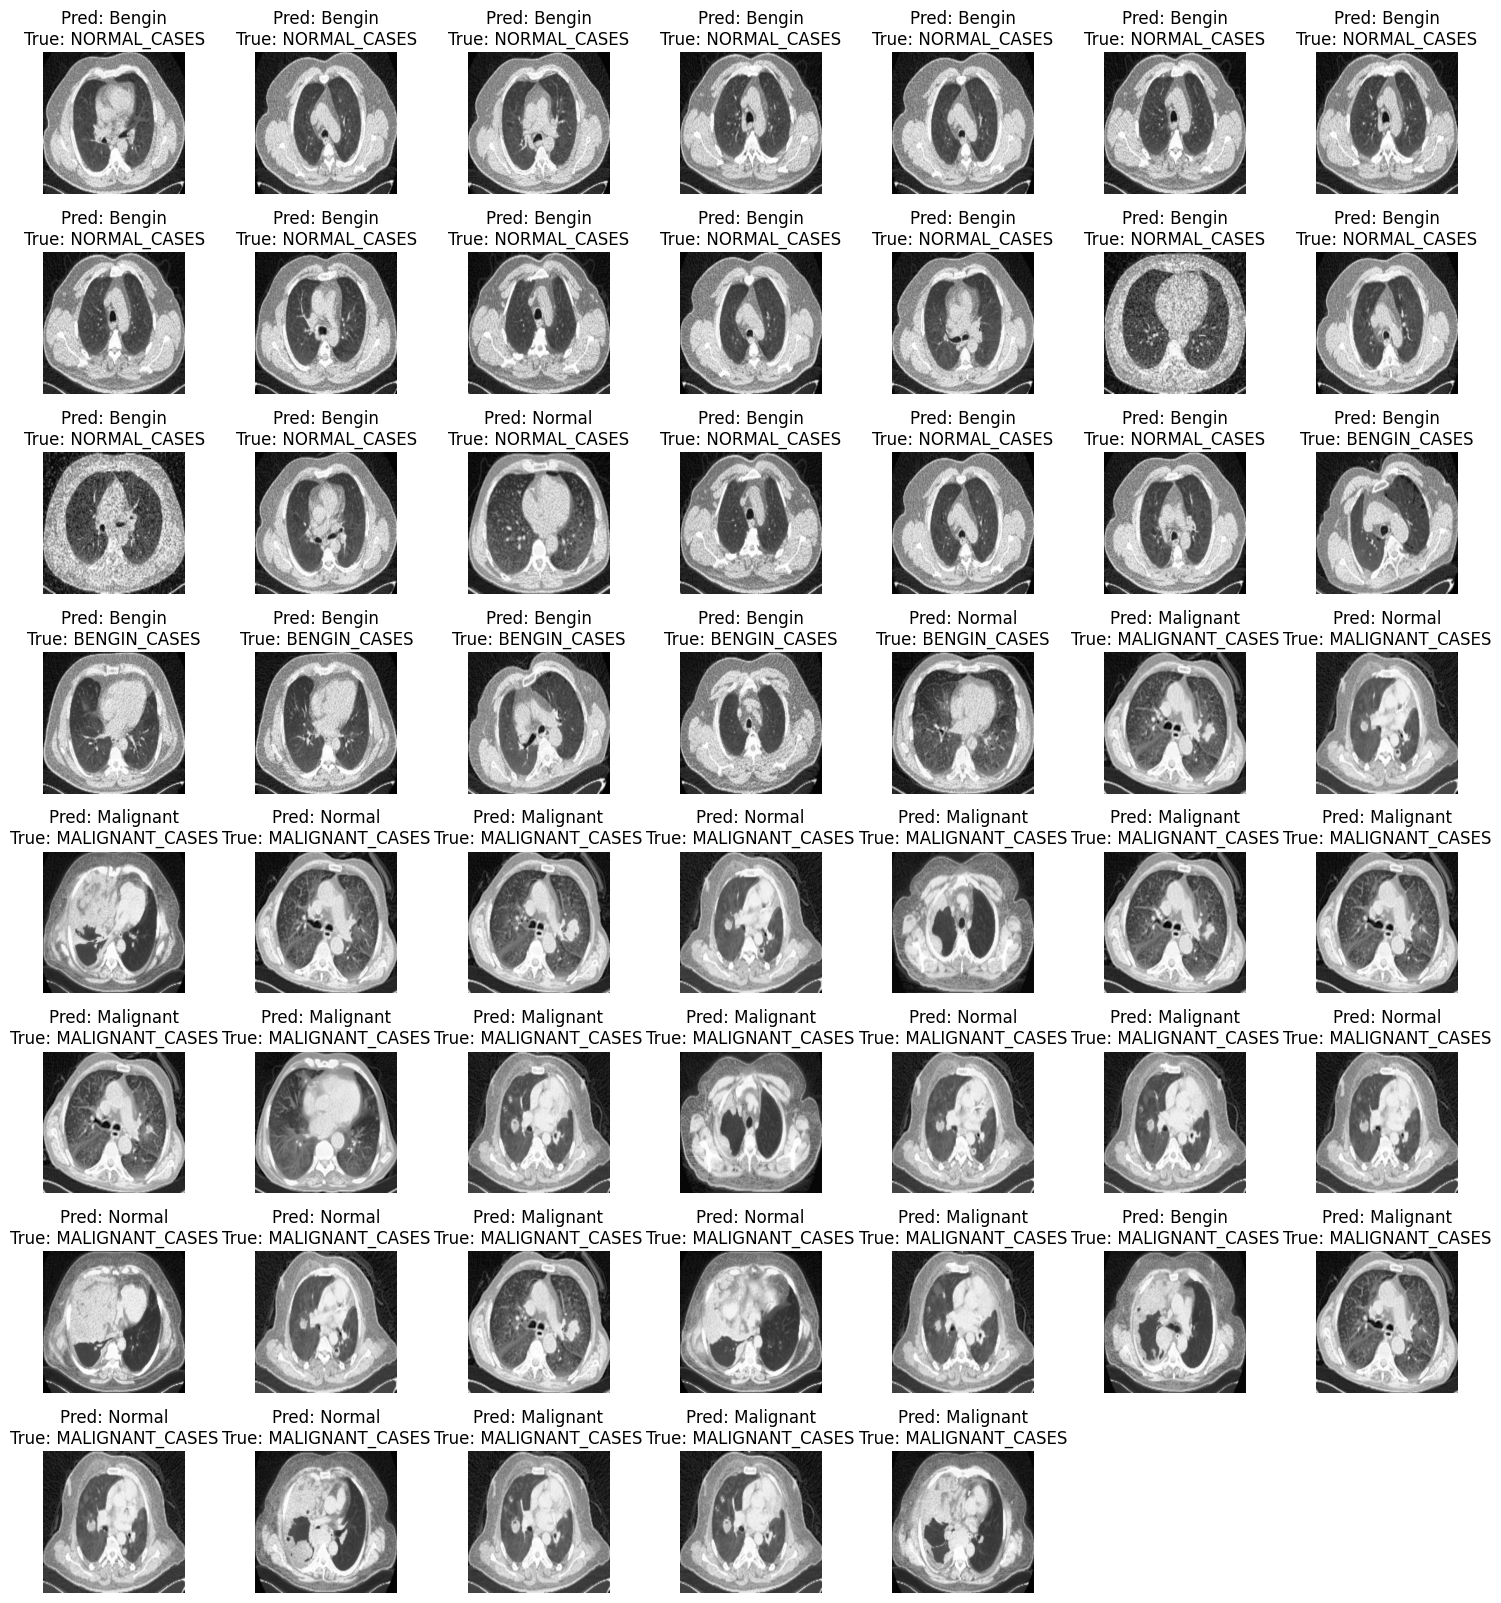

In [29]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model_path = '2023-11_Resnet50_model.h5'  # Replace with the path to your model file
model = load_model(model_path)

class_names = ['Bengin', 'Malignant', 'Normal']

# Path to the folder containing test images
test_folder_path = 'TEST_CROP/'  # Replace with the path to your test image folder

# Set the number of rows and columns for the subplot

num_rows = 100
num_cols = 7 # Adjust this based on the number of images you want in each row

# Counter for the subplot position
subplot_counter = 1

# Create a new figure for the subplot
plt.figure(figsize=(15, 200))

# Iterate over each subfolder (class) in the main folder
for true_class in os.listdir(test_folder_path):
    class_folder_path = os.path.join(test_folder_path, true_class)

    # Iterate over each file in the class subfolder
    for filename in os.listdir(class_folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Construct the full path to the image
            img_path = os.path.join(class_folder_path, filename)

            # Read and resize the image
            img = cv2.imread(img_path)
            img_resize = cv2.resize(img, (224, 224))

            # Make predictions
            pred = model.predict(np.expand_dims(img_resize, axis=0))

            # Get the predicted class index
            predicted_class_index = np.argmax(pred)

            # Check if the index is within the valid range
            if 0 <= predicted_class_index < len(class_names):
                # Get the corresponding class name
                output_class = class_names[predicted_class_index]

                # Add a subplot to the figure
                plt.subplot(num_rows, num_cols, subplot_counter)
                plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
                plt.title(f'Pred: {output_class}\nTrue: {true_class}')
                plt.axis('off')

                subplot_counter += 1

                # Break the loop if we have displayed enough images
                if subplot_counter > num_rows * num_cols:
                    break

    # Break the loop if we have displayed enough images
    if subplot_counter > num_rows * num_cols:
        break

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()
